# Introduction

Ces dernières années, le Covid a bousculé la vie des gens.
Pour accélérer le retour à la vie normale, fallait créer plusieurs méthodes pour détecter ce Virus. 
Les plus utilisés de nos jours sont les tests PCR, antigéniques et les auto-tests.

L'objectif de ce projet est d'utiliser l'image X-ray d'une personne pour déterminer s'elle a le covid, la pneumonia ou s'elle est saine.

Nous savons très bien que les réseaux de neurones sont le meilleur outil pour ce genre de tâches, c'est pour cela que nous allons implémenter, tester et comparer différentes architectures de réseaux de neurones.

Note : Vous pouvez télécharger le jeu de données à partir du lien suivant <a href='https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database'>dataset kaggle</a>

# Préparation de l'environnement

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import logging, os, shutil
logging.disable(logging.WARNING) 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Tensorflow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Préparation du jeu de données

Le jeu de données se compose des dossiers **Covid**, **Pneumonia** et **Normal**. Chaque dossier contient deux autres dossiers : 
* **images** qui contient les images X-ray de la catégorie correspondante (Covid-Pneumonia-Normal).
* **masks** qui contient les masques des poumons de chaque image (c'est-à-dire la position des poumons).

L'une des chose à faire est donc de masquer les images avant d'entrainer le modèle.

Remarque : On peut se demander pourquoi faut-il masquer les images ? et la raison est simple. Nous voulons que l'attention de notre modèle sera entierement alloué au poumons, car c'est au niveau des poumons qu'existe l'information recherché.

Voyons à quoi ressemblent nos images et leurs masques.

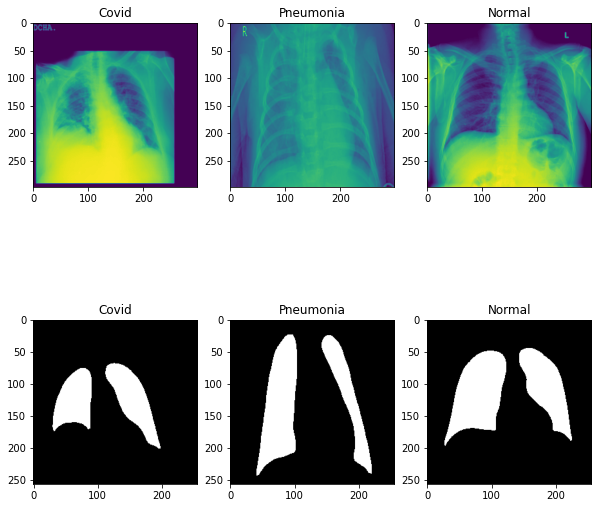

In [2]:
datapath = './dataset' # path to dataset
classes = ['Covid', 'Pneumonia', 'Normal'] # the target classes

fig = plt.figure(figsize = (10,10))
# Let's visualize an image from each category
# and the corresponding mask
for idx, c in enumerate(classes):
    # path to the folder of the corresponding class/category.
    class_path = os.path.join(datapath, c)
    # path to the images of the class
    images_path = os.path.join(class_path, 'images')
    # list of the image names
    image_names = os.listdir(images_path)
    # The path to the first image of the corresponding class
    image_path = os.path.join(images_path, image_names[0])
    # load the image 
    image = plt.imread(image_path)
    # visualize the image
    ax = plt.subplot(2,3, idx+1)
    ax.imshow(image)
    ax.set_title(c)
    # path to mask images
    masks_path = os.path.join(class_path, 'masks')
    # list of mask image names
    mask_names = os.listdir(masks_path)
    # the path to the first mask of the corresponding class
    mask_path = os.path.join(masks_path, mask_names[0])
    # load the image
    mask = plt.imread(mask_path)
    # Visualize the mask
    ax = plt.subplot(2,3, idx+4)
    ax.imshow(mask)
    ax.set_title(c) 
plt.show()

Maintenant, voyons à quoi ressemblent les images masquées.

In [3]:
# First : Create a function that masks the images.
def mask_image(image, mask):
    """
    Mask an image.

    Arguments: 
    ----------
    image : the image that we want to mask, it can either be a numpy array or a PIL.Image
    mask  : the corresponding mask, it can either be a numpy array or a PIL.Image

    Returns : 
    ---------
    masked_image : the masked image, as a numpy array.
    """
    # Transform the image and mask into numpy lists
    image = np.array(image.copy())
    mask = np.array(mask.copy())
    # mask the image
    masked_image = np.ma.masked_where(mask == 0, image)
    masked_image = masked_image.filled(0)
    # return the masked image
    return masked_image
    

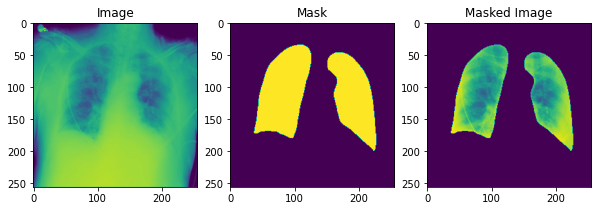

In [4]:
target_size = (256,256)
fig = plt.figure(figsize = (10,10))

# path to the first image/mask of the covid class.
image_name = "COVID-1.png"
image_path = os.path.join(datapath, "Covid", "images", image_name)
mask_path = os.path.join(datapath, "Covid", "masks", image_name)

# plot the image
image = np.array(Image.open(image_path).convert("L").resize(target_size))
ax = plt.subplot(1,3,1)
ax.imshow(image)
ax.set_title("Image")

# plot the mask
mask = np.array(Image.open(mask_path).convert("L").resize(target_size)) 
ax = plt.subplot(1,3,2)
ax.imshow(mask)
ax.set_title("Mask")

# plot the masked image
masked_image = mask_image(image, mask)
ax = plt.subplot(1,3,3)
ax.imshow(masked_image)
ax.set_title("Masked Image")

plt.show()


Ensuite, nous allons modifier les images en les masquant l'une après l'autre.
À chaque fois nous masquons une image nous allons l'enregistrer et supprimer le masque correspondant (Nous n'aurons plus besoin du masque).

In [5]:
for c in classes: # for each class 
    # class path
    class_path = os.path.join(datapath, c)
    # path to images
    images_path = os.path.join(class_path, 'images')
    # path to masks
    masks_path = os.path.join(class_path, 'masks')
    # list of image names
    image_names = os.listdir(images_path)
    # for each image in the previous list
    for image_name in image_names:
        # Load the image
        image_path = os.path.join(images_path, image_name)
        image = np.array(Image.open(image_path).convert("L").resize(target_size))
        # Load the mask
        mask_path = os.path.join(masks_path, image_name)
        mask = np.array(Image.open(mask_path).convert("L").resize(target_size)) 
        # Mask the image and save it.
        masked_image = mask_image(image, mask)
        im = Image.fromarray(masked_image)
        new_image_path = os.path.join(class_path, image_name)
        im.save(new_image_path)
        # We have saved the masked images in the parent 
        # folder ( Covid - Pneumonia - Normal )
    # Now we delete the 'images' and 'masks' folders
    shutil.rmtree(images_path)
    shutil.rmtree(masks_path)


Voyons à quoi ressemblent les nouvelles images masquées.

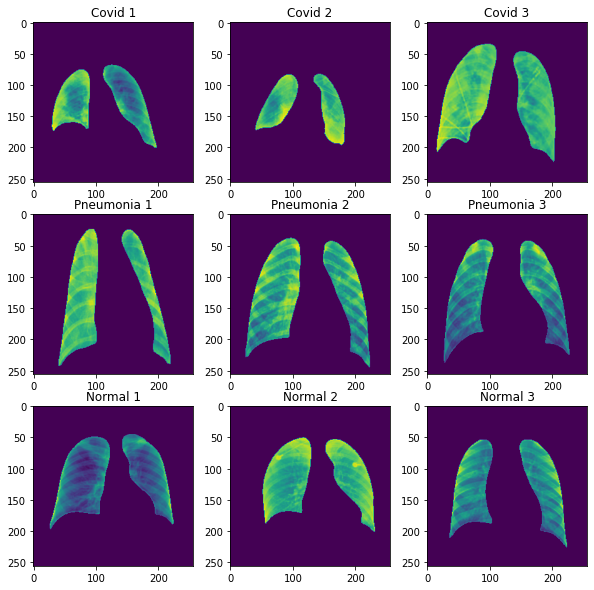

In [6]:
fig = plt.figure(figsize = (10,10))
for row_idx, c in enumerate(classes):
    class_path = os.path.join(datapath, c)
    image_names = os.listdir(class_path)
    # Let's visualize the first three images of each class.
    for image_idx in range(3):
        image_path = os.path.join(class_path, image_names[image_idx])
        image = plt.imread(image_path)
        ax = plt.subplot(3,3, (image_idx+1) + row_idx*3)
        ax.imshow(image)
        ax.set_title(c + " " + str(image_idx + 1))
plt.show()

In [7]:
for c in classes : 
    nb_images = len(os.listdir(os.path.join(datapath, c)))
    print(f"Le nombre d'images de la classe {c} est {nb_images}.")

Le nombre d'images de la classe Covid est 3616.
Le nombre d'images de la classe Pneumonia est 1345.
Le nombre d'images de la classe Normal est 10192.


Puisque je vais faire l'entrainement sur mon ordinateur personnelle, faut que je reduisent le nombre d'images d'entrainement, notamment ceux appartenant à la classe *Normal* (c'est la plus grande classe). Sinon l'entrainement prendera beaucoup de temps (puisque je n'ai pas un GPU).

Note : Je vais me limiter à 2000 images de la classe *Normal*.


In [8]:
nb_a_garder = 2000
classe = 'Normal'
classe_path = os.path.join(datapath, classe)
images = os.listdir(classe_path)
for idx, image_name in enumerate(images):
    image_path = os.path.join(classe_path, image_name)
    if idx >= nb_a_garder:
        os.remove(image_path)

nb_images = len(os.listdir(os.path.join(datapath, classe)))
print(f"Le nouveau nombre d'images de la classe {classe} est {nb_images}.")

Le nouveau nombre d'images de la classe Normal est 2000.


In [9]:
image_size = (256,256)

training = keras.utils.image_dataset_from_directory(
    datapath,
    
    label_mode='categorical',
    class_names=classes,
    color_mode='grayscale',
    batch_size=32,
    image_size=image_size,
    seed=42,
    validation_split=0.3,
    subset='training',
)

validation = keras.utils.image_dataset_from_directory(
    datapath,
    label_mode='categorical',
    class_names=classes,
    color_mode='grayscale',
    batch_size=32,
    image_size=image_size,
    seed=42,
    validation_split=0.3,
    subset='validation',
)

Found 6961 files belonging to 3 classes.
Using 4873 files for training.
Found 6961 files belonging to 3 classes.
Using 2088 files for validation.


# Créer le modèle de classification

## Architecture simple

Dans un premier temps, je vais implémenter une architecture simple pour faire de la classification d'image.

In [10]:
# Implement early stopping to stop the model if we see fit.
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 5)
# Implement model checkpoint to save the best version of the model.
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5",monitor= "accuracy", mode = "max", save_best_only=True)

In [11]:
input = layers.Input(shape=image_size + (1,))

x = layers.Rescaling(1.0 / 255)(input)
x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(input, outputs)
tf.keras.utils.plot_model(model, show_shapes= True)

# Compile the model
model.compile(optimizer= keras.optimizers.Adam(), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
# train the model
history = model.fit(training, epochs = 50, callbacks= [earlyStopping, modelCheckpoint])
# save the history in json file
# in case we want to plot the accuracy 
with open('history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
153/153 [==============================] - 54s 349ms/step - loss: 1.0507 - accuracy: 0.4794
Epoch 2/50
153/153 [==============================] - 58s 380ms/step - loss: 0.9694 - accuracy: 0.5333
Epoch 3/50
153/153 [==============================] - 57s 375ms/step - loss: 0.9336 - accuracy: 0.5541
Epoch 4/50
153/153 [==============================] - 58s 376ms/step - loss: 0.9028 - accuracy: 0.5752
Epoch 5/50
153/153 [==============================] - 59s 385ms/step - loss: 0.8823 - accuracy: 0.5931
Epoch 6/50
153/153 [==============================] - 56s 362ms/step - loss: 0.8611 - accuracy: 0.6093
Epoch 7/50
153/153 [==============================] - 55s 357ms/step - loss: 0.8552 - accuracy: 0.6050
Epoch 8/50
153/153 [==============================] - 56s 365ms/step - loss: 0.8235 - accuracy: 0.6306
Epoch 9/50
153/153 [==============================] - 58s 376ms/step - loss: 0.8170 - accuracy: 0.6321
Epoch 10/50
153/153 [==============================] - 64s 421ms/step - l

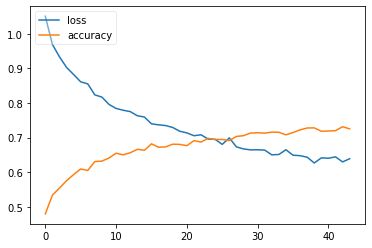

66/66 [==============================] - 6s 88ms/step - loss: 8.5438 - accuracy: 0.1906
La précision du modèle est : 19.06


In [13]:
# plot the accuracy and loss curves
fig = plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.legend(loc="upper left", fancybox=True, framealpha=0.4)
plt.show()

# La performance du modèle :
loss, accuracy = model.evaluate(validation)
print(f"La précision du modèle est : {accuracy*100:.2f}")

Selon les courbes de perte (loss) et de précision (accuracy), nous voyons que notre modèle s'entraine correctement à distinguer entre les trois classes (Covid-Pneumonia-Normal). 

Le modèle a atteint une précision de 19% (Jeu de données de test).
L'allure des courbes indique que le modèle pourra potentiellement atteindre de meilleures performances si nous augmentons le nombre d'epochs d'entrainement.

## Feature extraction

Dans cette partie, nous allons ré-entrainer le modèle précédent mais cette fois-ci en ajoutant une couche **d'extraction de caractéristiques (feature extraction)**.

Note : Nous allons utiliser VGG16 pour l'extraction de caractéristiques.

In [12]:
# Instanciate VGG16
VGG16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classifier_activation="softmax",
)

Pour chaque image, nous extrayons 256 caractéristiques.

Pour voir à quoi ressemble ces caractéristiques, nous allons visualiser les 16 premières caractéristiques extraites pour une image prise aléatoirement.

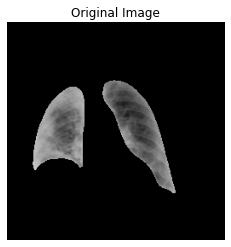

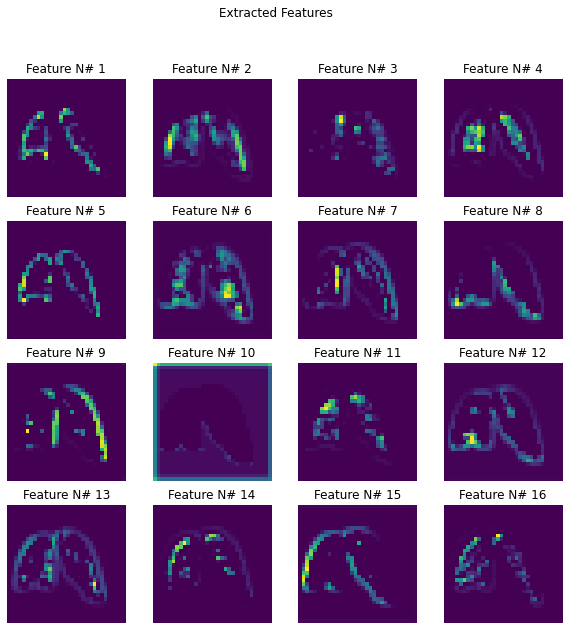

In [13]:
# Let's use the first covid image as an example.
image_name = os.listdir(os.path.join(datapath, 'Covid'))[0]
image_path = os.path.join(os.path.join(datapath, 'Covid'), image_name)
image = tf.keras.utils.load_img(image_path)

# Visualize the image
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Adapt image for prediction
image = tf.expand_dims(image, axis = 0)

# Feature extractor:
output_layer_name = 'block3_pool'
feature_extractor = tf.keras.Model(inputs = VGG16.inputs, outputs = VGG16.get_layer(output_layer_name).output)
features = feature_extractor.predict(image)

# Visualize features
fig = plt.figure(figsize = (10,10))
for idx in range(16):
    ax = plt.subplot(4,4,idx+1)
    ax.imshow(features[0, :, :, idx])
    ax.set_title(f"Feature N# {idx + 1}")
    ax.axis('off')
    fig.suptitle('Extracted Features')

Maintenant, nous allons recreer le modèle précédent mais cette fois-ci avec une couche supplémentaire  d'extraction de caractéristiques (basée sur VGG16).

Remarque : Puisque le VGG16 a été entrainée (pre-trained) avec des images en couleur (RGB channels), nous devons re-télécharger le jeu de donnée mais cette fois-ci avec les 3 chaines de couleurs.

In [14]:
# Reloading the data :
# --------------------

image_size = (256,256)

training_3d = keras.utils.image_dataset_from_directory(
    datapath,
    
    label_mode='categorical',
    class_names=classes,
    color_mode='rgb',
    batch_size=32,
    image_size=image_size,
    seed=42,
    validation_split=0.3,
    subset='training',
)

validation_3d = keras.utils.image_dataset_from_directory(
    datapath,
    label_mode='categorical',
    class_names=classes,
    color_mode='rgb',
    batch_size=32,
    image_size=image_size,
    seed=42,
    validation_split=0.3,
    subset='validation',
)

Found 6961 files belonging to 3 classes.
Using 4873 files for training.
Found 6961 files belonging to 3 classes.
Using 2088 files for validation.


In [15]:
headModel = VGG16.get_layer(output_layer_name).output
VGG16.trainable = False


# The following code was copied, to re-create the same model
# as the one seen above.
# The only difference is that we commented the first two lines.

# input = layers.Input(shape=image_size + (3,))
# x = layers.Rescaling(1.0 / 255)(input)
x = layers.Conv2D(32, 3, strides=2, padding="same")(headModel)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs = VGG16.inputs, outputs = outputs)
tf.keras.utils.plot_model(model, show_shapes= True)

# Compile the model
model.compile(optimizer= keras.optimizers.Adam(), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [130]:
# Implement early stopping to stop the model if we see fit.
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 5)
# Implement model checkpoint to save the best version of the model.
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("fe_best_model.h5",monitor= "accuracy", mode = "max", save_best_only=True)

# train the model
history = model.fit(training_3d, epochs = 10, callbacks= [earlyStopping, modelCheckpoint])
# save the history in json file
# in case we want to plot the accuracy 
with open('fe_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/10
153/153 [==============================] - 715s 5s/step - loss: 0.4669 - accuracy: 0.8174
Epoch 2/10
153/153 [==============================] - 752s 5s/step - loss: 0.3230 - accuracy: 0.8744
Epoch 3/10
153/153 [==============================] - 655s 4s/step - loss: 0.2593 - accuracy: 0.9038
Epoch 4/10
153/153 [==============================] - 652s 4s/step - loss: 0.2170 - accuracy: 0.9183
Epoch 5/10
153/153 [==============================] - 650s 4s/step - loss: 0.1812 - accuracy: 0.9300
Epoch 6/10
153/153 [==============================] - 650s 4s/step - loss: 0.1532 - accuracy: 0.9452
Epoch 7/10
153/153 [==============================] - 649s 4s/step - loss: 0.1339 - accuracy: 0.9524
Epoch 8/10
153/153 [==============================] - 649s 4s/step - loss: 0.1189 - accuracy: 0.9592
Epoch 9/10
153/153 [==============================] - 649s 4s/step - loss: 0.0949 - accuracy: 0.9690
Epoch 10/10
153/153 [==============================] - 644s 4s/step - loss: 0.0765 - accura

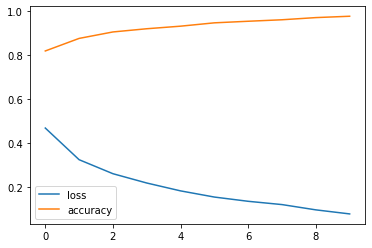

66/66 [==============================] - 291s 4s/step - loss: 0.3265 - accuracy: 0.8889
La précision du modèle est : 88.89%


In [135]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.legend()
plt.show()

# La performance du modèle :
loss, accuracy = model.evaluate(validation_3d)
print(f"La précision du modèle est : {accuracy*100:.2f}%")

* Sans l'extraction des caractéristiques, nous avons atteint une précision de 20% (presque) sur 50 epochs.
* Avec l'extraction des caractéristiques, nous avons atteint une précision de 88.8% sur seulement 10 epochs.

Cet exemple nous montre clairement l'intérêt de faire l'extraction des caractéristiques.

**Remarque** : même si le nombre d'epochs est petit dans le deuxième cas, le modèle a pris plus de temps pour l'entrainement. c'est normal, car cette fois-ci chaque image de taille 256x256x3 a été remplacé par ses caractéristiques (256 images de taille 34x34).



## EfficientNetB2

EfficientNetB2 est un modèle de deep learning très puissant pour les taches de classification.

Il contient 9.2M paramètres (relativement petit par rapport à d'autres architectures) et il atteint une précision de 80.1% sur le jeu de données imagenet (94.9% top-five accuracy).

Nous allons faire du transfer-learning, c'est à dire nous allons instancier l'architecture et les poids du modèle EfficientNetB2 qui a déjà été entrainé sur le jeu de données **imagenet**, figer ses couches, puis ajouter de nouvelles couches personnalisées à la sortie du modèle.

In [14]:
# Implement early stopping to stop the model if we see fit.
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 5)
# Implement model checkpoint to save the best version of the model.
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("tuned_best_model.h5",monitor= "accuracy", mode = "max", save_best_only=True)

In [15]:
baseModel = keras.applications.EfficientNetB2(
    include_top = False,
    weights = 'imagenet',
    input_shape= image_size + (3,),
    classes=3,
    classifier_activation="softmax",
)

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = layers.AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(128, activation="relu")(headModel)
headModel = layers.Dropout(0.5)(headModel)
headModel = layers.Dense(3, activation="softmax")(headModel)

# Freeze the layers of the base model
for layer in baseModel.layers:
    layer.trainable = False

model = keras.Model(inputs=baseModel.input, outputs=headModel)

model.compile(optimizer= keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
# train the model
history = model.fit(training, epochs = 50, callbacks= [modelCheckpoint, earlyStopping])
# save the history in json file
# in case we want to plot the accuracy 
with open('tuned_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/50
153/153 [==============================] - 241s 2s/step - loss: 0.5247 - accuracy: 0.7765
Epoch 2/50
153/153 [==============================] - 243s 2s/step - loss: 0.3936 - accuracy: 0.8293
Epoch 3/50
153/153 [==============================] - 246s 2s/step - loss: 0.3793 - accuracy: 0.8299
Epoch 4/50
153/153 [==============================] - 251s 2s/step - loss: 0.3687 - accuracy: 0.8340
Epoch 5/50
153/153 [==============================] - 244s 2s/step - loss: 0.3445 - accuracy: 0.8492
Epoch 6/50
153/153 [==============================] - 226s 1s/step - loss: 0.3328 - accuracy: 0.8541
Epoch 7/50
153/153 [==============================] - 249s 2s/step - loss: 0.3177 - accuracy: 0.8537
Epoch 8/50
153/153 [==============================] - 251s 2s/step - loss: 0.3161 - accuracy: 0.8600
Epoch 9/50
153/153 [==============================] - 251s 2s/step - loss: 0.3045 - accuracy: 0.8687
Epoch 10/50
153/153 [==============================] - 249s 2s/step - loss: 0.3086 - accura

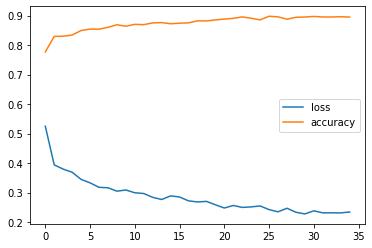

66/66 [==============================] - 96s 1s/step - loss: 0.2852 - accuracy: 0.9128
La précision du modèle est : 91.28


In [21]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.legend()
plt.show()

# La performance du modèle :
loss, accuracy = model.evaluate(validation)
print(f"La précision du modèle est : {accuracy*100:.2f}")

En faisant le transfer-learning, notre modèle EfficientNetB2 a atteint une précision de 91.28%.
Sur 50 epochs, c'est un resultat plutôt satisfaisant.